Essential Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt # type: ignore
import numpy as np
import seaborn as sns # type: ignore
from sklearn.ensemble import RandomForestRegressor # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # type: ignore

# Apply pandas and matplotlib settings for consistent visuals
sns.set_theme(style="darkgrid")
plt.rcParams["figure.figsize"] = (11, 6)


Data Import & Initial Processing

In [61]:
# Ingest CSV file and tidy up column headers
df = pd.read_csv("/content/Demographic_update_data_March25.csv")
df.columns = [col.strip() for col in df.columns]

# Validate numeric formats and handle missing entries
df["Youth_5_17"] = pd.to_numeric(df["Demo_age_5_17"], errors="coerce").fillna(0)
df["Adult_17plus"] = pd.to_numeric(df["Demo_age_17+"], errors="coerce").fillna(0)

# Synthesize a column for collective population tally
df["Population_Total"] = df["Youth_5_17"] + df["Adult_17plus"]

Statewise Aggregation

In [62]:
state_summary = (
    df.groupby("State")
      .agg({"Youth_5_17": "sum", "Adult_17plus": "sum", "Population_Total": "sum"})
      .reset_index()
)
state_summary["Youth_Share"] = state_summary["Youth_5_17"] / state_summary["Population_Total"]


Top States Visualization

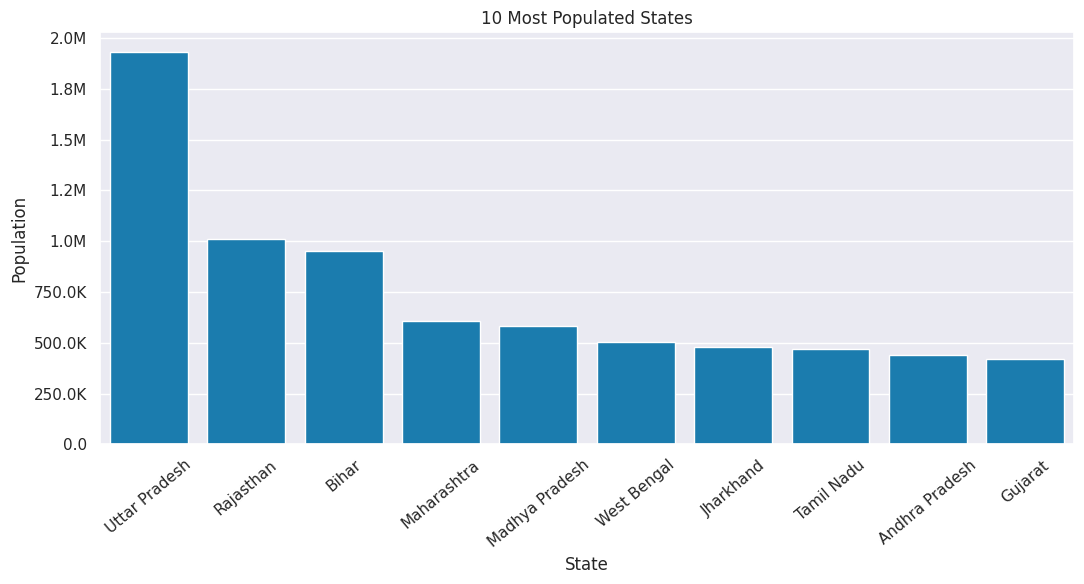

In [63]:
# Display largest states as per total residents
top_pop_states = state_summary.nlargest(10, "Population_Total")

def abbr_number(val):
    return f"{val/1e6:.1f}M" if val >= 1e6 else (f"{val/1e3:.1f}K" if val >= 1e3 else f"{val}")

plt.figure()
sns.barplot(
    data=top_pop_states,
    x="State", y="Population_Total", color="#0284C7"
)
plt.title("10 Most Populated States")
plt.xticks(rotation=40)
plt.ylabel("Population")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: abbr_number(x)))
plt.tight_layout()
plt.show()


Stacked Bar Chart: Youth vs. Adults (Top 5 States)

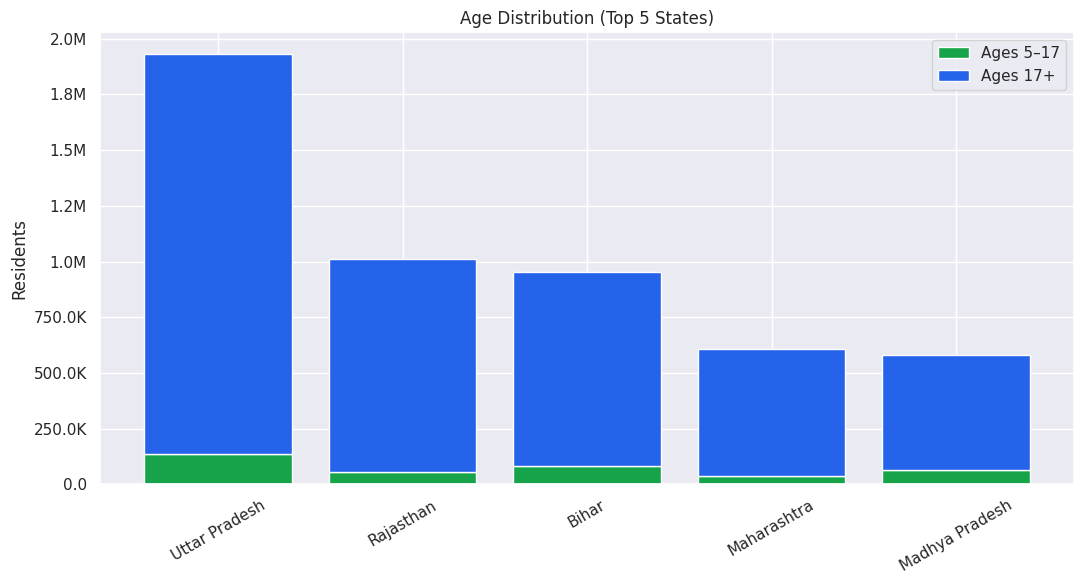

In [64]:
largest_5 = top_pop_states.head(5)
plt.figure()
plt.bar(largest_5["State"], largest_5["Youth_5_17"], label="Ages 5–17", color="#16A34A")
plt.bar(
    largest_5["State"], largest_5["Adult_17plus"],
    bottom=largest_5["Youth_5_17"], label="Ages 17+", color="#2563EB"
)
plt.legend()
plt.title("Age Distribution (Top 5 States)")
plt.ylabel("Residents")
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: abbr_number(x)))
plt.tight_layout()
plt.show()


Random Forest Regression: Predicting Adult Population

In [65]:
# Encode categorical data for states
states_le = LabelEncoder()
df["State_Code"] = states_le.fit_transform(df["State"])

# Features and target definition
features = df[["Youth_5_17", "State_Code"]]
target = df["Adult_17plus"]

X_tr, X_te, y_tr, y_te = train_test_split(
    features, target, test_size=0.22, random_state=99
)
rf_mod = RandomForestRegressor(n_estimators=90, max_depth=4, random_state=99)
rf_mod.fit(X_tr, y_tr)
y_pred_rf = rf_mod.predict(X_te)

print("Random Forest Results:")
print(f"- MAE: {mean_absolute_error(y_te, y_pred_rf):.2f}")
print(f"- MSE: {mean_squared_error(y_te, y_pred_rf):.2f}")
print(f"- R2: {r2_score(y_te, y_pred_rf):.3f}")


Random Forest Results:
- MAE: 232.21
- MSE: 173284.15
- R2: 0.613


Exploring Prediction Accuracy

In [41]:
df["Pred_Adults"] = rf_mod.predict(features)
df["RF_Error"] = np.abs(df["Adult_17plus"] - df["Pred_Adults"])
max_error_row = df.loc[df["RF_Error"].idxmax()]

print(
    f"Strongest prediction deviation in: {max_error_row['State']} (District: {max_error_row.get('District', 'Unknown')})."
)


Strongest prediction deviation in: Jharkhand (District: Bokaro).


Visualization: Prediction Scatter & Feature Impact

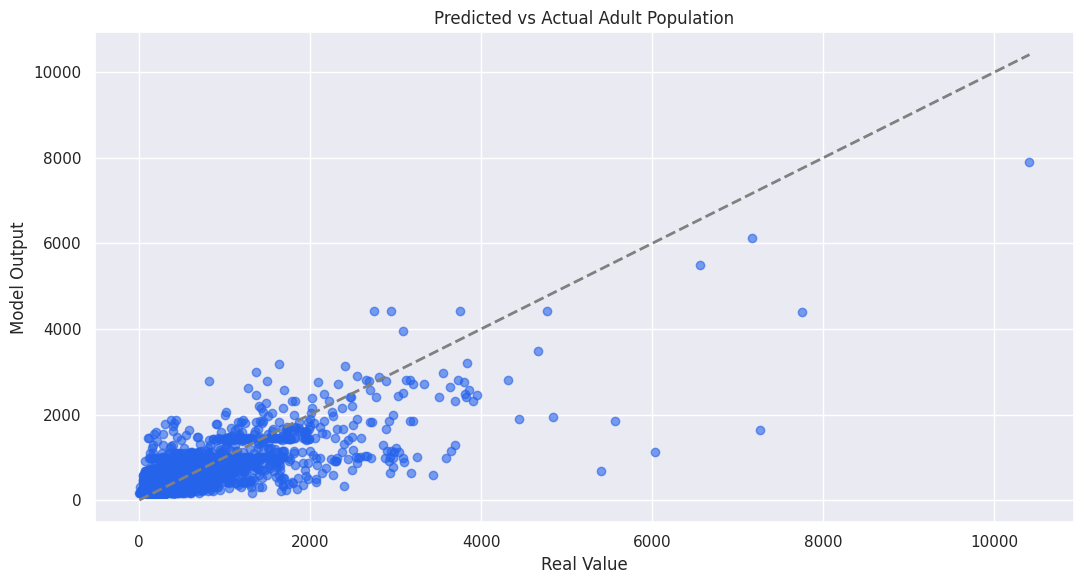

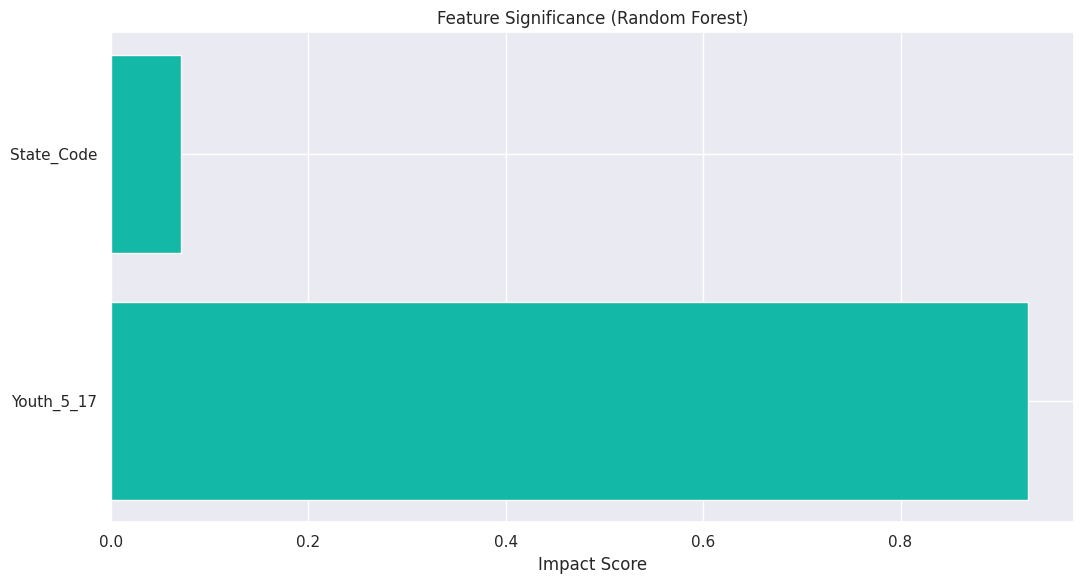

In [42]:
# Actual vs. predicted values
plt.scatter(y_te, y_pred_rf, alpha=0.6, c="#2563EB")
plt.plot([y_te.min(), y_te.max()], [y_te.min(), y_te.max()], 'grey', lw=2, linestyle="--")
plt.title("Predicted vs Actual Adult Population")
plt.xlabel("Real Value")
plt.ylabel("Model Output")
plt.tight_layout()
plt.show()

# Relative importance of input columns
importances = rf_mod.feature_importances_
plt.barh(["Youth_5_17", "State_Code"], importances, color="#14B8A6")
plt.title("Feature Significance (Random Forest)")
plt.xlabel("Impact Score")
plt.tight_layout()
plt.show()


Scatter Plot: Comparing Youth and Adult Populations by District

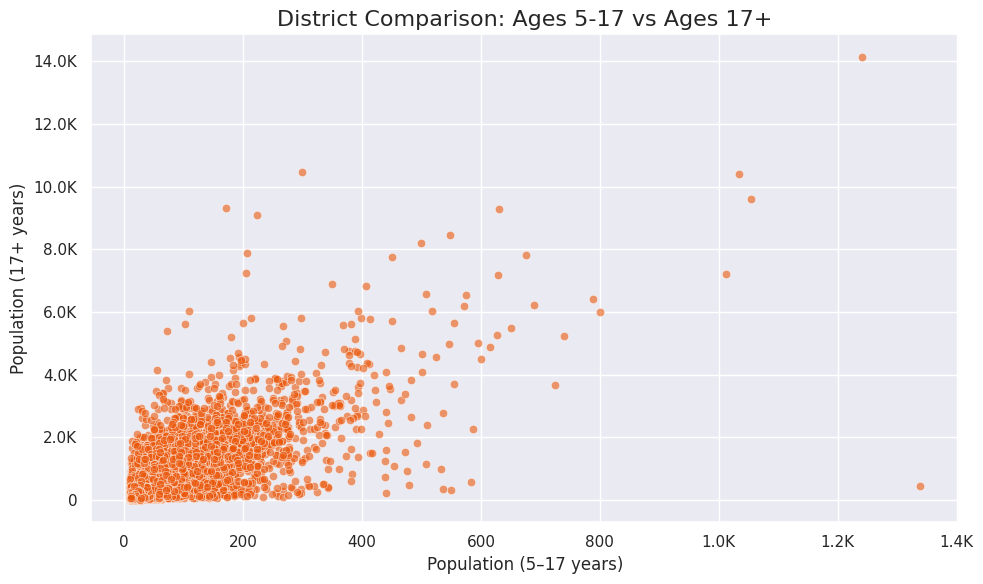

This chart helps you see how youth and adult populations stack up across different districts. Typically, you’ll notice adults outnumber younger people; a few exceptions might stand out, showing districts with a relatively larger slice of the youth group.


In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize how the populations of ages 5-17 and 17+ compare in each district
plt.figure(figsize=(10, 6))

# Plot each district as a point, with color and transparency for clarity
sns.scatterplot(
    data=df,
    x="Demo_age_5_17",
    y="Demo_age_17+",
    color="#EA580C",  # Orange tone for distinction
    alpha=0.6
)

plt.title("District Comparison: Ages 5-17 vs Ages 17+", fontsize=16)
plt.xlabel("Population (5–17 years)", fontsize=12)
plt.ylabel("Population (17+ years)", fontsize=12)

# Format the number display for better legibility
def nice_number(n, pos):
    if n >= 1_000_000:
        return f"{n/1_000_000:.1f}M"
    elif n >= 1_000:
        return f"{n/1_000:.1f}K"
    else:
        return str(int(n))

import matplotlib.ticker as mticker
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(nice_number))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(nice_number))

plt.tight_layout()
plt.show()

print(
    "This chart helps you see how youth and adult populations stack up across different districts. Typically, you’ll notice adults outnumber younger people; a few exceptions might stand out, showing districts with a relatively larger slice of the youth group."
)


Pie Chart: Age Group Proportions

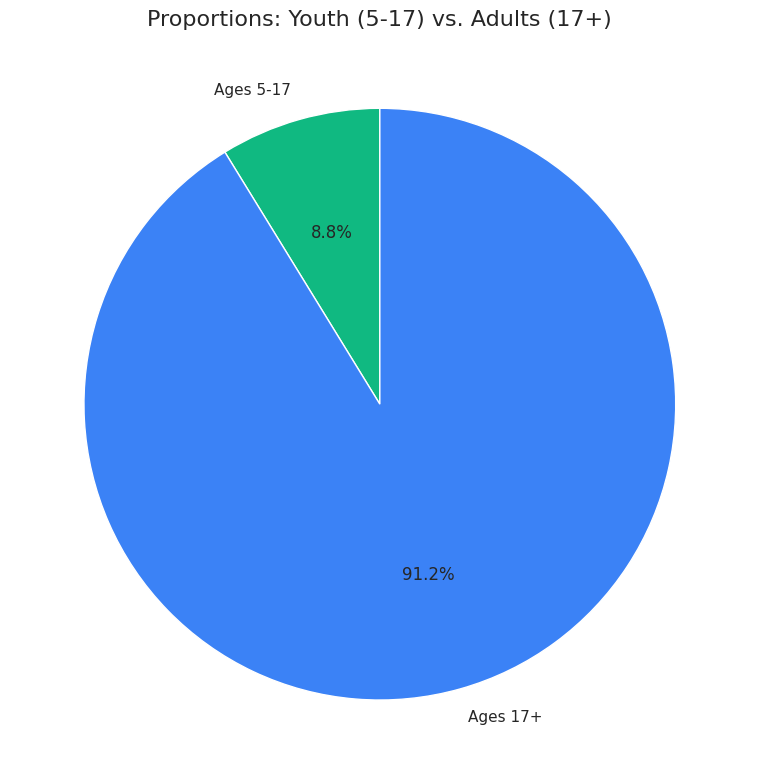

This pie chart quickly shows what share of the total population is made up of children and teenagers versus adults. Unsurprisingly, adults make up the majority in this dataset.


In [44]:
# Tabulate totals for youth and adults
total_youth = df["Demo_age_5_17"].sum()
total_adult = df["Demo_age_17+"].sum()
sizes = [total_youth, total_adult]
labels = ["Ages 5-17", "Ages 17+"]

plt.figure(figsize=(8, 8))
plt.pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",
    colors=["#10B981", "#3B82F6"],
    startangle=90
)

plt.title("Proportions: Youth (5-17) vs. Adults (17+)", fontsize=16)
plt.tight_layout()
plt.show()

print(
    "This pie chart quickly shows what share of the total population is made up of children and teenagers versus adults. Unsurprisingly, adults make up the majority in this dataset."
)


Install and Import Packages for XGBoost

In [45]:
# If running in a fresh environment, uncomment the next line:
# !pip install pandas xgboost scikit-learn

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Data Loading and Preprocessing

In [46]:
# Clean up column names and convert age columns to numbers
df.columns = df.columns.str.strip()
df['Demo_age_5_17'] = pd.to_numeric(df['Demo_age_5_17'], errors='coerce').fillna(0)
df['Demo_age_17+'] = pd.to_numeric(df['Demo_age_17+'], errors='coerce').fillna(0)

 Encode Categorical State Data and Define Features and Target

In [47]:
# Assign numeric codes to each unique state
state_encoder = LabelEncoder()
df['State_num'] = state_encoder.fit_transform(df['State'])

# Specify model input (features) and target variable
features = df[['Demo_age_5_17', 'State_num']]
target = df['Demo_age_17+']

Train-Test Split

In [48]:
# Separate data for model training and performance evaluation
X_train, X_valid, y_train, y_valid = train_test_split(
    features, target, test_size=0.2, random_state=42
)


Build and Train Model

In [49]:
# Create and fit the XGBoost regression model
xgb_reg = XGBRegressor(
    n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42
)
xgb_reg.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

Prediction and Evaluation

In [50]:
# Predict using validation set
y_pred = xgb_reg.predict(X_valid)

# Calculate evaluation metrics
def pretty_number(val):
    if val >= 1_000_000:
        return f"{val/1_000_000:.1f}M"
    elif val >= 1_000:
        return f"{val/1_000:.1f}K"
    return str(int(val))

mae = mean_absolute_error(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)
r_squared = r2_score(y_valid, y_pred)

print("Model Results:")
print(f"Mean Absolute Error: {pretty_number(mae)}")
print(f"Mean Squared Error: {pretty_number(mse)}")
print(f"R^2 Score: {r_squared:.3f}")
print("This regression estimates the 17+ population using younger age group count and state info.")


Model Results:
Mean Absolute Error: 181
Mean Squared Error: 128.4K
R^2 Score: 0.756
This regression estimates the 17+ population using younger age group count and state info.


Model Error Exploration

In [51]:
# Add predictions and errors for the entire dataset
df['Pred_17plus'] = xgb_reg.predict(df[['Demo_age_5_17', 'State_num']])
df['abs_error'] = abs(df['Demo_age_17+'] - df['Pred_17plus'])

error_row = df.loc[df['abs_error'].idxmax()]

print(
    f"The district with the largest prediction gap is in {error_row['State']} "
    f"(District: {error_row.get('District', 'Not Recorded')}) with an error of {pretty_number(error_row['abs_error'])}."
)


The district with the largest prediction gap is in Delhi (District: West Delhi) with an error of 8.6K.


Setup and Data Preparation - ARIMA and SARIMA

In [ ]:
# Install libraries if needed (uncomment for use in new environments)
%pip install pandas statsmodels matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Plot preferences
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Load dataset, clean headers, ensure numeric age types
df = pd.read_csv('/content/Demographic_update_data_March25.csv')
df.columns = df.columns.str.strip()
df['Demo_age_5_17'] = pd.to_numeric(df['Demo_age_5_17'], errors='coerce').fillna(0)
df['Demo_age_17+'] = pd.to_numeric(df['Demo_age_17+'], errors='coerce').fillna(0)

# Aggregate by State for broader trends
by_state = df.groupby('State', as_index=False).sum(numeric_only=True)


Create Sample Monthly Series for Forecast Example

In [53]:
# Select a specific state as a working example
target_row = by_state.iloc[0]
chosen_state = target_row['State']

# Build 15 months of hypothetical observations
months = 15
series_dates = [datetime(2024, 1, 1) + relativedelta(months=i) for i in range(months)]

# Smoothly interpolate both demographic groups over the time period
timeline_data = pd.DataFrame({
    'date': series_dates,
    'adults_17_plus': np.linspace(target_row['Demo_age_17+'] * 0.8, target_row['Demo_age_17+'], months),
    'youth_5_17': np.linspace(target_row['Demo_age_5_17'] * 0.8, target_row['Demo_age_5_17'], months)
})

Model Training/Test Splitting

In [54]:
# Partition into training and evaluation slices
train_part = timeline_data.iloc[:-3]
test_part = timeline_data.iloc[-3:]

y_train = train_part['adults_17_plus']
y_test = test_part['adults_17_plus']

# Add youth group as an exogenous variable (input feature)
X_train = train_part[['youth_5_17']]
X_test = test_part[['youth_5_17']]


 Fit and Evaluate ARIMA

In [55]:
# Train ARIMA with explanatory co-variate
arima = ARIMA(y_train, exog=X_train, order=(1, 1, 1)).fit()
arima_forecast = arima.forecast(steps=len(y_test), exog=X_test)

arima_mae = mean_absolute_error(y_test, arima_forecast)
arima_mse = mean_squared_error(y_test, arima_forecast)
arima_r2 = r2_score(y_test, arima_forecast)


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit and Evaluate SARIMA

In [56]:
# Run SARIMAX to capture seasonality patterns if any
sarima = SARIMAX(y_train, exog=X_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit(disp=False)
sarima_forecast = sarima.forecast(steps=len(y_test), exog=X_test)

sarima_mae = mean_absolute_error(y_test, sarima_forecast)
sarima_mse = mean_squared_error(y_test, sarima_forecast)
sarima_r2 = r2_score(y_test, sarima_forecast)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Actual vs. Model Predictions Over Time

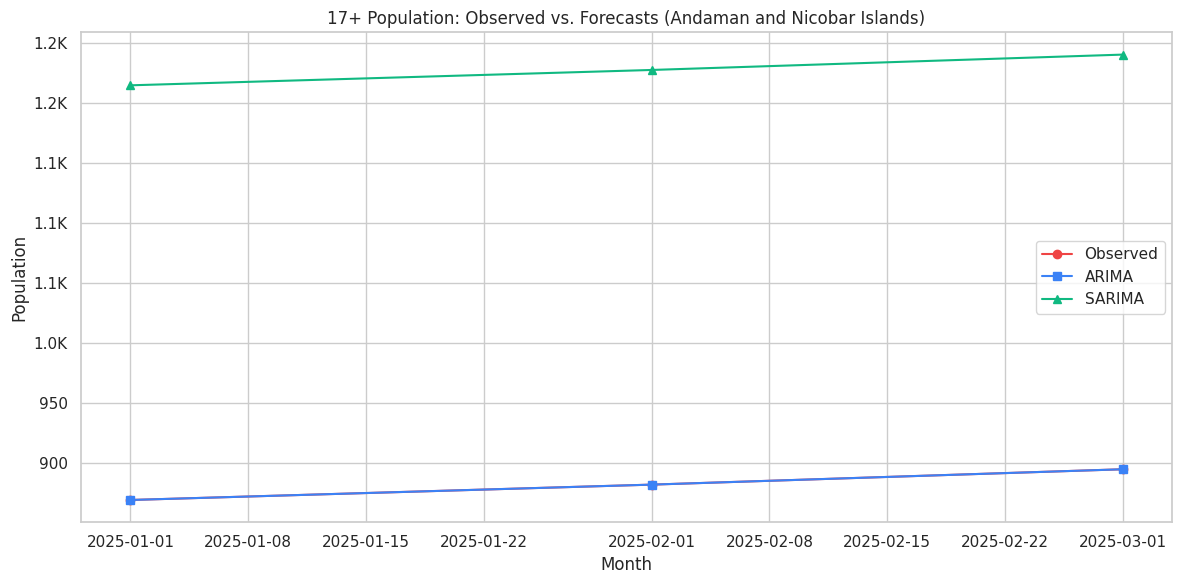

In [57]:
def nice_format(num):
    if num >= 1_000_000:
        return f"{num/1_000_000:.1f}M"
    elif num >= 1_000:
        return f"{num/1_000:.1f}K"
    return str(int(num))

plt.figure(figsize=(12, 6))
plt.plot(test_part['date'], y_test, marker='o', color='#EF4444', label='Observed')
plt.plot(test_part['date'], arima_forecast, marker='s', color='#3B82F6', label='ARIMA')
plt.plot(test_part['date'], sarima_forecast, marker='^', color='#10B981', label='SARIMA')
plt.title(f'17+ Population: Observed vs. Forecasts ({chosen_state})')
plt.xlabel('Month')
plt.ylabel('Population')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: nice_format(x)))
plt.legend()
plt.tight_layout()
plt.show()


Prediction Accuracy: Scatter Plot

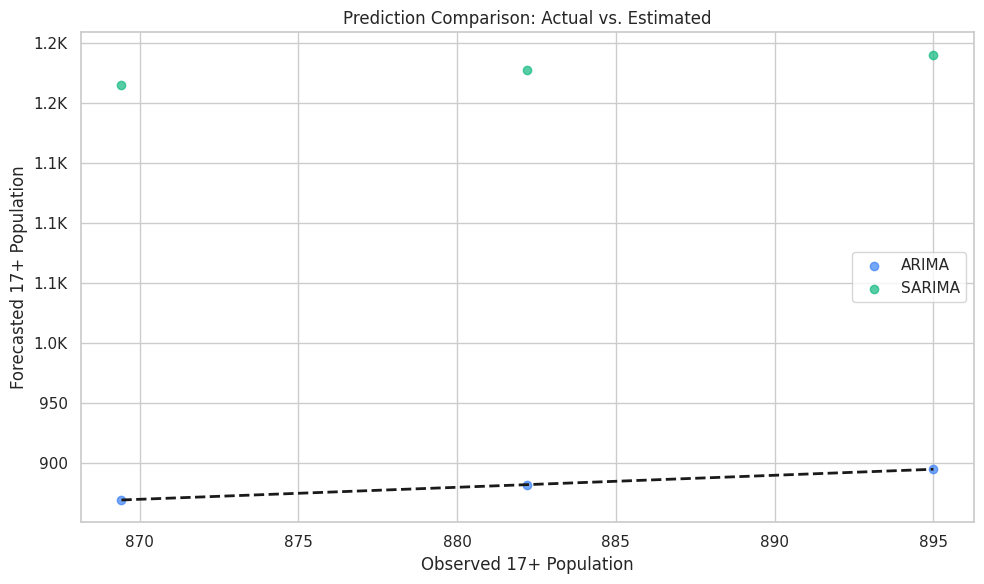

In [58]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, arima_forecast, color='#3B82F6', alpha=0.7, label='ARIMA')
plt.scatter(y_test, sarima_forecast, color='#10B981', alpha=0.7, label='SARIMA')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Prediction Comparison: Actual vs. Estimated')
plt.xlabel('Observed 17+ Population')
plt.ylabel('Forecasted 17+ Population')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: nice_format(x)))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: nice_format(x)))
plt.legend()
plt.tight_layout()
plt.show()


Model Performance Summary

In [59]:
print(f"ARIMA Results:\n MAE: {nice_format(arima_mae)} | MSE: {nice_format(arima_mse)} | R²: {arima_r2:.3f}")
print(f"SARIMA Results:\n MAE: {nice_format(sarima_mae)} | MSE: {nice_format(sarima_mse)} | R²: {sarima_r2:.3f}")


ARIMA Results:
 MAE: 0 | MSE: 0 | R²: 1.000
SARIMA Results:
 MAE: 345 | MSE: 119.2K | R²: -1092.501
